In [6]:
import duckdb
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def db_create(sf):
    con = duckdb.connect(f'database_{sf}.duckdb')

    ### creating tables

    con.execute("""
    CREATE TABLE customer
    (
        C_CUSTKEY       INTEGER,
        C_NAME          VARCHAR,
        C_ADDRESS       VARCHAR,
        C_CITY          VARCHAR,
        C_NATION        VARCHAR,
        C_REGION        VARCHAR,
        C_PHONE         VARCHAR,
        C_MKTSEGMENT    VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE lineorder
    (
        LO_ORDERKEY             INTEGER,
        LO_LINENUMBER           INTEGER,
        LO_CUSTKEY              INTEGER,
        LO_PARTKEY              INTEGER,
        LO_SUPPKEY              INTEGER,
        LO_ORDERDATE            VARCHAR,
        LO_ORDERPRIORITY        VARCHAR,
        LO_SHIPPRIORITY         INTEGER,
        LO_QUANTITY             INTEGER,
        LO_EXTENDEDPRICE        INTEGER,
        LO_ORDTOTALPRICE        INTEGER,
        LO_DISCOUNT             INTEGER,
        LO_REVENUE              INTEGER,
        LO_SUPPLYCOST           INTEGER,
        LO_TAX                  INTEGER,
        LO_COMMITDATE           VARCHAR,
        LO_SHIPMODE             VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE part
    (
            P_PARTKEY       INTEGER,
            P_NAME          VARCHAR,
            P_MFGR          VARCHAR,
            P_CATEGORY      VARCHAR,
            P_BRAND         VARCHAR,
            P_COLOR         VARCHAR,
            P_TYPE          VARCHAR,
            P_SIZE          INTEGER,
            P_CONTAINER     VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE supplier
    (
            S_SUPPKEY       INTEGER,
            S_NAME          VARCHAR,
            S_ADDRESS       VARCHAR,
            S_CITY          VARCHAR,
            S_NATION        VARCHAR,
            S_REGION        VARCHAR,
            S_PHONE         VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE date
    (
            D_DATEKEY            VARCHAR,
            D_DATE               VARCHAR,
            D_DAYOFWEEK          VARCHAR,
            D_MONTH              VARCHAR,
            D_YEAR               INTEGER,
            D_YEARMONTHNUM       INTEGER,
            D_YEARMONTH          VARCHAR,
            D_DAYNUMINWEEK       INTEGER,
            D_DAYNUMINMONTH      INTEGER,
            D_DAYNUMINYEAR       INTEGER,
            D_MONTHNUMINYEAR     INTEGER,
            D_WEEKNUMINYEAR      INTEGER,
            D_SELLINGSEASON      VARCHAR,
            D_LASTDAYINWEEKFL    INTEGER,
            D_LASTDAYINMONTHFL   INTEGER,
            D_HOLIDAYFL          INTEGER,
            D_WEEKDAYFL          INTEGER
    )
    """)
    con.close()

In [ ]:
# db_create(1)

In [ ]:
# db_create(10)

In [ ]:
# db_create(50)

In [ ]:
def data_import(data_path, sf):
    con = duckdb.connect(f'database_{sf}.duckdb')
    
    try:
        con.execute(f"COPY customer FROM '{data_path}/customer.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing customer data: {e}")
    
    try:
        con.execute(f"COPY lineorder FROM '{data_path}/lineorder.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing lineorder data: {e}")
    
    try:
        con.execute(f"COPY part FROM '{data_path}/part.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing part data: {e}")
    
    try:
        con.execute(f"COPY supplier FROM '{data_path}/supplier.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing supplier data: {e}")
    
    try:
        con.execute(f"COPY date FROM '{data_path}/date.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing date data: {e}")
    
    con.close()


In [ ]:
# data_import('data/sf_1',1)

In [ ]:
# data_import('data/sf_10',10)

In [ ]:
# data_import('data/sf_50',50)

In [2]:
def query_run(sf, thread_count, folder,run_no):
    # Ensure the folder exists
    profiling_folder = f'results/tc_{thread_count}/{folder}'
    os.makedirs(profiling_folder, exist_ok=True)

    # Connect to the DuckDB database
    con = duckdb.connect(f'database_{sf}.duckdb')

    # Set PRAGMA settings for thread count
    con.execute(f"PRAGMA threads={thread_count};")

    # Define the queries to run
    queries = [
    "SELECT sum(LO_EXTENDEDPRICE * LO_DISCOUNT) AS REVENUE FROM lineorder, date WHERE LO_ORDERDATE = D_DATEKEY AND D_YEAR = 1993 AND LO_DISCOUNT BETWEEN 1 AND 3 AND LO_QUANTITY < 25;",
    "SELECT sum(LO_REVENUE), D_YEAR, P_BRAND FROM lineorder, date, part, supplier WHERE LO_ORDERDATE = D_DATEKEY AND LO_PARTKEY = P_PARTKEY AND LO_SUPPKEY = S_SUPPKEY AND P_CATEGORY = 'MFGR#12' AND S_REGION = 'AMERICA' GROUP BY D_YEAR, P_BRAND ORDER BY D_YEAR, P_BRAND;",
    "SELECT C_NATION, S_NATION, D_YEAR, sum(LO_REVENUE) AS REVENUE FROM customer, lineorder, supplier, date WHERE LO_CUSTKEY = C_CUSTKEY AND LO_SUPPKEY = S_SUPPKEY AND LO_ORDERDATE = D_DATEKEY AND C_REGION = 'ASIA' AND S_REGION = 'ASIA' AND D_YEAR >= 1992 AND D_YEAR <= 1997 GROUP BY C_NATION, S_NATION, D_YEAR ORDER BY D_YEAR ASC, REVENUE DESC;",
    "SELECT D_YEAR, C_NATION, sum(LO_REVENUE - LO_SUPPLYCOST) AS PROFIT FROM date, customer, supplier, part, lineorder WHERE LO_CUSTKEY = C_CUSTKEY AND LO_SUPPKEY = S_SUPPKEY AND LO_PARTKEY = P_PARTKEY AND LO_ORDERDATE = D_DATEKEY AND C_REGION = 'AMERICA' AND S_REGION = 'AMERICA' AND (P_MFGR = 'MFGR#1' OR P_MFGR = 'MFGR#2') GROUP BY D_YEAR, C_NATION ORDER BY D_YEAR, C_NATION;"
    ]

    # Run each query, generate query plans, and save profiling results
    for idx, query in enumerate(queries, start=1):
        profiling_output = f"{profiling_folder}/query_{idx}_profile_run_{run_no}.json"
        
        # Enable profiling in JSON format
        con.execute("PRAGMA enable_profiling='json';")
        con.execute(f"PRAGMA profiling_output='{profiling_output}';")

        # Execute the query
        con.execute(query)
        
        # Disable profiling after each query
        con.execute("PRAGMA disable_profiling;")
    
    # Close the database connection
    con.close()


In [3]:
for i in range(1,11):
    query_run(1,1,'sf_1',i)
    query_run(1,4,'sf_1',i)
    query_run(1,8,'sf_1',i)

In [4]:
for i in range(1,11):
    query_run(10,1,'sf_10',i)
    query_run(10,4,'sf_10',i)
    query_run(10,8,'sf_10',i)

In [5]:
for i in range(1,11):
    query_run(50,1,'sf_50',i)
    query_run(50,4,'sf_50',i)
    query_run(50,8,'sf_50',i)

### Visualizations

In [17]:
def get_data(tc,sf):
    base_dir = f"results/{tc}/{sf}"  # Replace with the actual path

    # Initialize a list to store data
    data_list = []

    # Iterate through all files in the directory
    for file_name in sorted(os.listdir(base_dir)):
        if file_name.endswith(".json"):
            # Extract query and run number from the file name
            parts = file_name.split("_")
            query_number = int(parts[1])  # e.g., "1" in "query_1"
            run_number = int(parts[-1].split(".")[0])  # e.g., "0" in "run_0.json"

            # Load JSON data
            file_path = os.path.join(base_dir, file_name)
            with open(file_path, "r") as file:
                data = json.load(file)

            # Append data to the list
            data_list.append({
                "query": query_number,
                "run_number": run_number,
                "latency": data["latency"],
                "cpu_time": data["cpu_time"],
                "cumulative_rows_scanned": data['cumulative_rows_scanned']
            })

    # Create a Pandas DataFrame from the list
    df = pd.DataFrame(data_list)
    return df

In [128]:
df_8_1 = get_data('tc_8','sf_1')[['cpu_time','latency','run_number','query']]
df_4_1 = get_data('tc_4','sf_1')[['cpu_time','latency','run_number','query']]
df_1_1 = get_data('tc_1','sf_1')[['cpu_time','latency','run_number','query']]

In [129]:
df_8_1['Scaling Factor'] = 1
df_4_1['Scaling Factor'] = 1
df_1_1['Scaling Factor'] = 1

df_8_1['Threads'] = 8
df_4_1['Threads'] = 4
df_1_1['Threads'] = 1

In [130]:
df_8_50 = get_data('tc_8','sf_50')[['cpu_time','latency','run_number','query']]
df_4_50 = get_data('tc_4','sf_50')[['cpu_time','latency','run_number','query']]
df_1_50 = get_data('tc_1','sf_50')[['cpu_time','latency','run_number','query']]

In [131]:
df_8_50['Scaling Factor'] = 50
df_4_50['Scaling Factor'] = 50
df_1_50['Scaling Factor'] = 50

df_8_50['Threads'] = 8
df_4_50['Threads'] = 4
df_1_50['Threads'] = 1

In [132]:
df_8_10 = get_data('tc_8','sf_10')[['cpu_time','latency','run_number','query']]
df_4_10 = get_data('tc_4','sf_10')[['cpu_time','latency','run_number','query']]
df_1_10 = get_data('tc_1','sf_10')[['cpu_time','latency','run_number','query']]

In [133]:
df_8_10['Scaling Factor'] = 10
df_4_10['Scaling Factor'] = 10
df_1_10['Scaling Factor'] = 10

df_8_10['Threads'] = 8
df_4_10['Threads'] = 4
df_1_10['Threads'] = 1

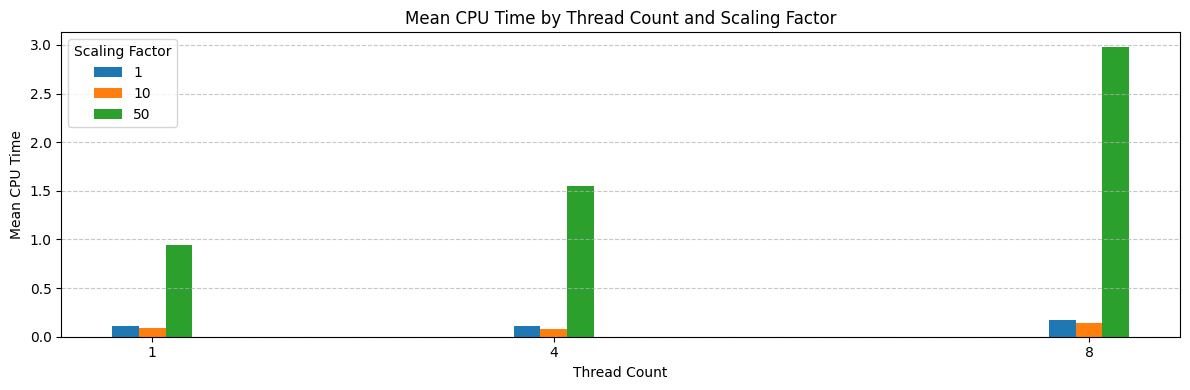

In [134]:
# Combining all dataframes
combined_df = pd.concat([df_1_1, df_4_1, df_8_1,df_1_10, df_4_10, df_8_10, df_1_50, df_4_50, df_8_50])

# Grouping and calculating the mean
mean_cpu_times = combined_df.groupby(['Scaling Factor', 'Threads'])['cpu_time'].mean().reset_index()

plt.figure(figsize=(12, 4))
bar_width = 0.2
positions = [-bar_width, 0, bar_width]

for i, sf in enumerate(mean_cpu_times['Scaling Factor'].unique()):
    subset = mean_cpu_times[mean_cpu_times['Scaling Factor'] == sf]
    plt.bar(
        subset['Threads'] + positions[i],
        subset['cpu_time'],
        width=bar_width,
        label=sf
    )

plt.xlabel('Thread Count')
plt.ylabel('Mean CPU Time')
plt.title('Mean CPU Time by Thread Count and Scaling Factor')
plt.xticks([1, 4, 8], ['1', '4', '8'])
plt.legend(title='Scaling Factor')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

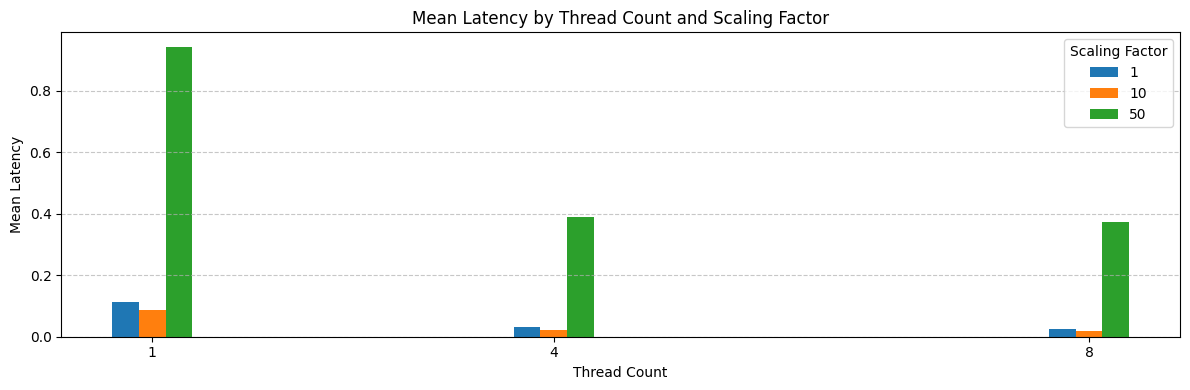

In [124]:
# Combining all dataframes
combined_df = pd.concat([df_1_1, df_4_1, df_8_1,df_1_10, df_4_10, df_8_10, df_1_50, df_4_50, df_8_50])

# Grouping and calculating the mean
mean_cpu_times = combined_df.groupby(['Scaling Factor', 'Threads'])['latency'].mean().reset_index()

plt.figure(figsize=(12, 4))
bar_width = 0.2
positions = [-bar_width, 0, bar_width]

for i, sf in enumerate(mean_cpu_times['Scaling Factor'].unique()):
    subset = mean_cpu_times[mean_cpu_times['Scaling Factor'] == sf]
    plt.bar(
        subset['Threads'] + positions[i],
        subset['latency'],
        width=bar_width,
        label=sf
    )

plt.xlabel('Thread Count')
plt.ylabel('Mean Latency')
plt.title('Mean Latency by Thread Count and Scaling Factor')
plt.xticks([1, 4, 8], ['1', '4', '8'])
plt.legend(title='Scaling Factor')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [136]:
df_1 = combined_df[combined_df['Scaling Factor'] == 1]

In [137]:
df_1

,cpu_time,latency,run_number,query,Scaling Factor,Threads
0,0.093123,0.093755,0,1,1,1
1,0.029389,0.029732,1,1,1,1
2,0.029643,0.030023,2,1,1,1
3,0.032507,0.032885,3,1,1,1
4,0.029176,0.029523,4,1,1,1
...,...,...,...,...,...,...
35,0.228638,0.035683,5,4,1,8
36,0.244084,0.036949,6,4,1,8
37,0.233752,0.036337,7,4,1,8
38,0.235102,0.035333,8,4,1,8


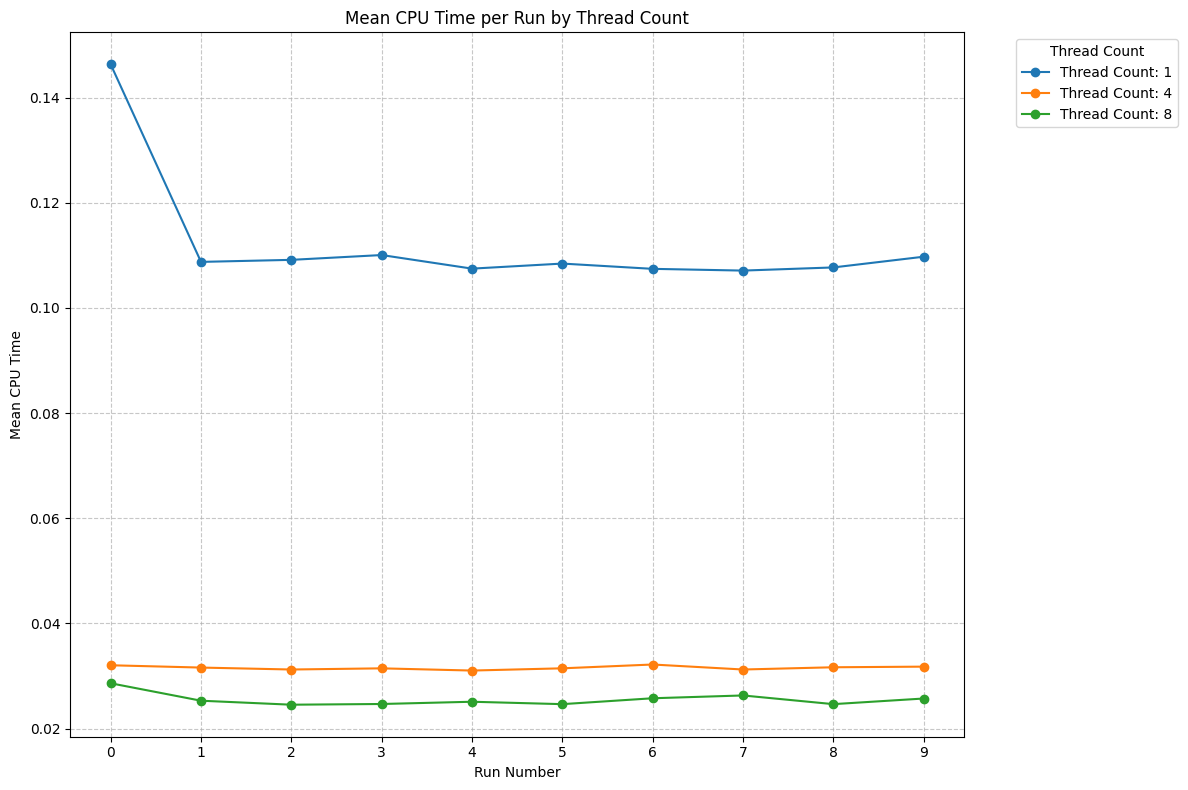

In [141]:
# Grouping by Thread Count, Run Number, Scaling Factor, and Query to calculate mean CPU Time
mean_cpu_time_by_run_thread = df_1.groupby(['Threads', 'run_number'])['latency'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(12, 8))

for thread_count in mean_cpu_time_by_run_thread['Threads'].unique():
    subset = mean_cpu_time_by_run_thread[mean_cpu_time_by_run_thread['Threads'] == thread_count]
    plt.plot(
        subset['run_number'],
        subset['latency'],
        marker='o',
        linestyle='-',
        label=f'Thread Count: {thread_count}'
    )

plt.xlabel('Run Number')
plt.ylabel('Mean CPU Time')
plt.title('Mean CPU Time per Run by Thread Count')
plt.xticks(mean_cpu_time_by_run_thread['run_number'].unique())
plt.legend(title='Thread Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [68]:
def plot_figure(df,column,title,y):
    plt.figure(figsize=(10, 6))
    # df = df[df['query'].isin([2,3,4])]
    for query in df['query'].unique():
        query_data = df[df['query'] == query].sort_values(by="run_number")
        plt.plot(query_data["run_number"], query_data[column], marker='o', label=f"Query {query}")

    plt.title(f"{title} for All Queries")
    plt.xlabel("Run Number")
    plt.ylabel(f"{y}")
    plt.legend()
    plt.grid(True)
    plt.show()

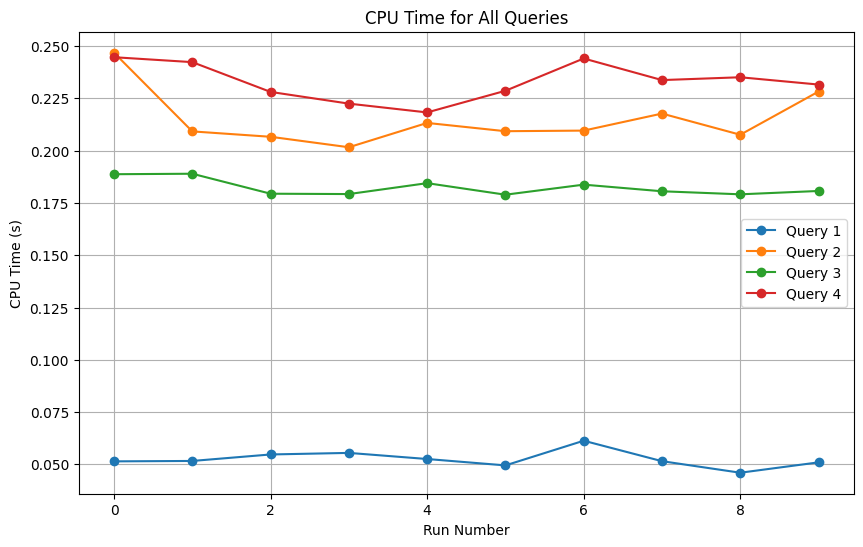

In [69]:
plot_figure(df_8_1,'cpu_time','CPU Time','CPU Time (s)')

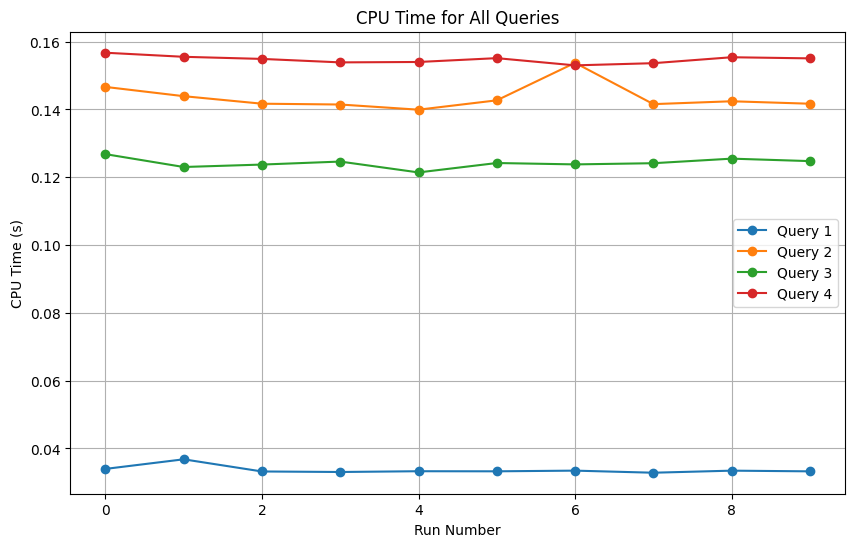

In [70]:
plot_figure(df_4_1,'cpu_time','CPU Time','CPU Time (s)')

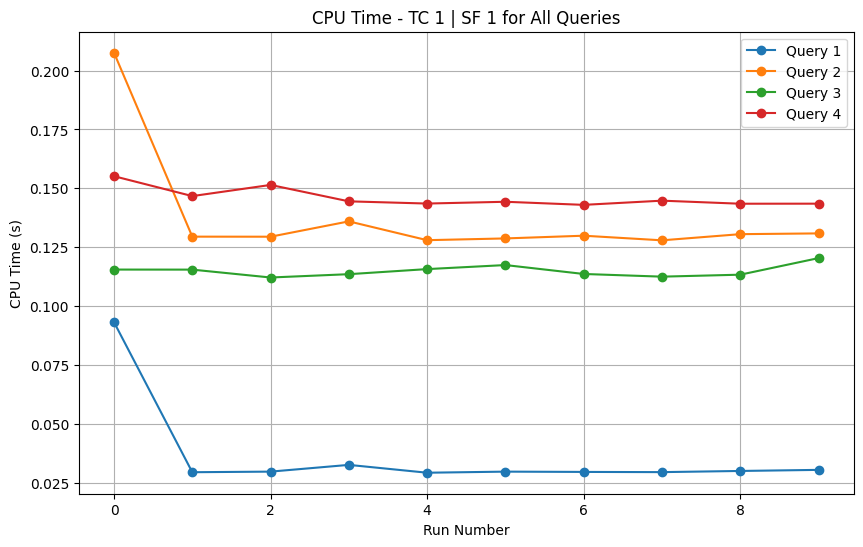

In [73]:
plot_figure(df_1_1,'cpu_time','CPU Time - TC 1 | SF 1','CPU Time (s)')